In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os
import numpy as np
from dateutil.parser import *
from dateutil.relativedelta import relativedelta

# Global Variable Declarations and Helper Functions

In [3]:
# Dictionary to convert from ACS geo_id to House Price Index MSA
acs_to_hpi = {
    12060:'Atlanta-Sandy Springs-Alpharetta, GA',
    12580:'Baltimore-Columbia-Towson, MD',
    14460:'Boston, MA (MSAD)',
    16980:'Chicago-Naperville-Evanston, IL (MSAD)',
    17140:'Cincinnati, OH-KY-IN',
    17460:'Cleveland-Elyria, OH',
    19100:'Dallas-Plano-Irving, TX (MSAD)',
    19740:'Denver-Aurora-Lakewood, CO',
    19820:'Detroit-Dearborn-Livonia, MI (MSAD)',
    26420:'Houston-The Woodlands-Sugar Land, TX',
    28140:'Kansas City, MO-KS',
    31080:'Los Angeles-Long Beach-Glendale, CA (MSAD)',
    33100:'Miami-Miami Beach-Kendall, FL (MSAD)',
    33340:'Milwaukee-Waukesha, WI',
    33460:'Minneapolis-St. Paul-Bloomington, MN-WI',
    35620:'New York-Jersey City-White Plains, NY-NJ (MSAD)',
    37980:'Philadelphia, PA (MSAD)',
    38060:'Phoenix-Mesa-Chandler, AZ',
    38300:'Pittsburgh, PA',
    38900:'Portland-Vancouver-Hillsboro, OR-WA',
    40140:'Riverside-San Bernardino-Ontario, CA',
    41740:'San Diego-Chula Vista-Carlsbad, CA',
    41860:'San Francisco-San Mateo-Redwood City, CA (MSAD)',
    41180:'St. Louis, MO-IL',
    45300:'Tampa-St. Petersburg-Clearwater, FL',
    47900:'Washington-Arlington-Alexandria, DC-VA-MD-WV (MSAD)',
}

# Dictionary to convert from ACS geo_id to Consumer Price Index MSA
acs_to_cpi = {
    12060:'Atlanta-Sandy Springs-Roswell, GA',
    12580:'Baltimore-Columbia-Towson, MD',
    14460:'Boston-Cambridge-Newton, MA-NH',
    16980:'Chicago-Naperville-Elgin, IL-IN-WI',
    17140:'Cincinnati-Hamilton, OH-KY-IN',
    17460:'Cleveland-Akron, OH',
    19100:'Dallas-Fort Worth-Arlington, TX',
    19740:'Denver-Aurora-Lakewood, CO',
    19820:'Detroit-Warren-Dearborn, MI',
    26420:'Houston-The Woodlands-Sugar Land, TX',
    28140:'Kansas City, MO-KS',
    31080:'Los Angeles-Long Beach-Anaheim, CA',
    33100:'Miami-Fort Lauderdale-West Palm Beach, FL',
    33340:'Milwaukee-Racine, WI',
    33460:'Minneapolis-St.Paul-Bloomington, MN-WI',
    35620:'New York-Newark-Jersey City, NY-NJ-PA',
    37980:'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD',
    38060:'Phoenix-Mesa-Scottsdale, AZ',
    38300:'Pittsburgh, PA',
    38900:'Portland-Salem, OR-WA',
    40140:'Riverside-San Bernardino-Ontario, CA',
    41740:'San Diego-Carlsbad, CA',
    41860:'San Francisco-Oakland-Hayward, CA',
    41180:'St. Louis, MO-IL',
    45300:'Tampa-St. Petersburg-Clearwater, FL',
    47900:'Washington-Arlington-Alexandria, DC-VA-MD-WV',
}

# Dictionary to convert from ACS geo_id to Zillow MSA Region ID
acs_to_zillow = {
    12060:394347,
    12580:394358,
    14460:394404,
    16980:394463,
    17140:394466,
    17460:394475,
    19100:394514,
    19740:394530,
    19820:394532,
    26420:394692,
    28140:394735,
    31080:753899,
    33100:394856,
    33340:394862,
    33460:394865,
    35620:394913,
    37980:394974,
    38060:394976,
    38300:394982,
    38900:394998,
    40140:395025,
    41740:395056,
    41860:395057,
    41180:395121,
    45300:395148,
    47900:395209,
}

# Function to convert House Price Index Year, and Frequency to Datetime Date
def hpi_date(row):
    if row.frequency != "quarterly":
        raise Exception("frequency not quarterly")
    date_map_quarterly = {
        "1":1,
        "2":4,
        "3":7,
        "4":10,
    }
    month = date_map_quarterly["{}".format(row.period)]
    date = datetime.date(row.yr, month, 1)
    return date

# Function to convert Consumer Price Index Year, and Period to Datetime Date
def cpi_date(row):
    cpi_date_map = {
            "M01":1,
            "M02":2,
            "M03":3,
            "M04":4,
            "M05":5,
            "M06":6,
            "M07":7,
            "M08":8,
            "M09":9,
            "M10":10,
            "M11":11,
            "M12":12,
            "M13":12,
            "S01":6,
            "S02":12,
            "S03":12
    }
    month = cpi_date_map[row.period]
    date = datetime.date(row.year, month, 1)
    return date

# Function to get last day of the month (needed for querying zillow dataframe)
def last_day_of_month(date):
    if date.month == 12:
        return date.replace(day=31)
    return date.replace(month=date.month+1, day=1) - datetime.timedelta(days=1)

def calc_hpi_cpi_price_to_rent(geo_id, name, name_cpi, name_hpi, name_zillow):
    # Filter hpi_df by place_name
    # Use the all-transaction "flavor" which includes new mortgages originated and refinances 
    temp_hpi = hpi_df.loc[(hpi_df["place_name"]==name_hpi) & 
           (hpi_df["hpi_flavor"]=="all-transactions")
          ].sort_values("date")
    
    # Get area code for cpi by filtering by name_cpi 
    area_code = cpi_df_areas.loc[cpi_df_areas["area_name"]==name_cpi].area_code.item()
    # Get all cpi records that are for specifc area_code
    # Filter item_code SEHA which is the series code for "residence in U.S. city average, all urban consumers"
    # Grab all records that are not seasonally adjusted 
    temp_cpi = cpi_df[(cpi_df["area_code"]==area_code) & 
       (cpi_df["item_code"]=="SEHA") &
       (cpi_df["seasonal"]=="U") 
      ].sort_values("date")
    
    # Delcare empty dataframe to use to store computed values
    price_to_rent_df = pd.DataFrame(columns={"name", "date", "rent", "price", "price_to_rent"})
    # Grab unique datas from both HPI and CPI dataframes for target area
    dates = set(list(temp_hpi.date.unique())  + list(temp_cpi.date.unique()))
    
    # Get max date for CPI data
    cpi_max_date = temp_cpi.date.max()
    # Get max date for HPI data
    hpi_max_date = temp_hpi.date.max()
    
    # Get max value for CPI using cpi_max_date
    cpi_max_index = temp_cpi.loc[temp_cpi["date"]==cpi_max_date].sort_values("period").iloc[0].value
    # Get max value for HPI using hpi_max_date
    hpi_max_index = temp_hpi.loc[temp_hpi["date"]==hpi_max_date].index_nsa.item()
    
    # Get ACS max year for target area using geo_id to filter 
    acs_max_year = cbsa_df.loc[(cbsa_df["geo_id"]==geo_id)].year.max()
    # Cast cpi_max_date year to int type and see if larger than ACS max year 
    if int(cpi_max_date.strftime("%Y"))>acs_max_year:
        # If CPI max date is larger than ACS max date set year to ACS max date
        year = acs_max_year
    else:
        # IF CPI date is equal to or less than ACS max date set year to CPI max date
        year = int(cpi_max_date.strftime("%Y"))
    
    # Get most recent rent data from ACS data to be used to calculate rent from CPI index
    # Use the year variable set above to get rent for appropriate year
    most_recent_rent = cbsa_df.loc[(cbsa_df["geo_id"]==geo_id) & (cbsa_df["year"]==year
                  )].median_contract_rent.item()
    # Get most recent home value from zillow data
    # Use HPI max date and filter dataframe by pasing hpi date to last_day_of_month function
    most_recent_home_val = zillow_df.loc[(zillow_df["RegionID"]==name_zillow),
                  last_day_of_month(hpi_max_date).strftime("%Y-%m-%e")].item()
    
    # Loop through unique dates list created above
    for n, date in enumerate(sorted(dates)):
        # Get CPI values that are less than or equal to date
        cpi_max_date = temp_cpi.loc[(temp_cpi["date"]<=date)]
        if not cpi_max_date.empty:
            # If cpi_max_date is not empty sort the values and get max date
            cpi_max_date = cpi_max_date.sort_values("date", ascending=False).iloc[0].date
        else:
            # If no values, continue since we cannot compute price to rent ratio if rent index data is N/A
            continue
        # Get values that are equal to cpi_max_date and sort by period
        temp_cpi_df = temp_cpi.loc[(temp_cpi["date"]==cpi_max_date)].sort_values("period")
        # Get first value from temp_cpi_df
        cpi_val = temp_cpi_df.iloc[0].value

        # Get HPI values that are less than or equal to date
        hpi_max_date = temp_hpi.loc[(temp_hpi["date"]<=date)]
        if not hpi_max_date.empty:
            # If hpi_max_date is not empty sort the values and get max date
            hpi_max_date = hpi_max_date.sort_values("date", ascending=False).iloc[0].date
        else: # If no values, continue since we cannot compute price to rent ratio if price index data is N/A
            continue
        # Get HPI value for where date is equal to hpi_max_date
        hpi_val = temp_hpi.loc[temp_hpi["date"]==hpi_max_date].index_nsa.item()
        
        # Compute rent value by taking the quotient of cpi_value for this date and the cpi index value from cpi_max_index
        # Multiply the quotient by the most_recent_rent variable declared outside of the loop
        rent_val = cpi_val/cpi_max_index*most_recent_rent
        # Compute price value by taking the quotient of hpi_val for this date and the hpi index value from hpi_max_index
        # Multiply the quotient by the most_recent_home_val variable declared outside of the loop
        home_val = hpi_val/hpi_max_index*most_recent_home_val
        # Compute the price to rent ratio by takign the quotient of home_val and 12 months worth of rent (rent_val x 12)
        price_to_rent = home_val/(rent_val*12)
        # Add records to new row in price_to_rent_df
        price_to_rent_df.loc[n] = {"date":date, 
                                   "name":name,
                                   "rent":rent_val, 
                                   "price":home_val, 
                                   "price_to_rent":price_to_rent
                                  } 
    return price_to_rent_df
    

# Load and Transform Various Datasets using Pandas for use in Analysis 

The code underneath will take a moment to run if you are re-calculating the price to rent ratio data from the HPI and CPI datasets  

In [432]:
# Run if the hpi_and_cpi_computed_historical csv file does not exist
if not os.path.isfile("data/hpi_and_cpi_computed_historical.csv"): 
    # Load in House Price Index data 
    hpi_df = pd.read_csv("data/HPI.csv")
    # Filter dataframe to records that are of level MSA
    hpi_df = hpi_df.loc[(hpi_df["level"]=="MSA")]
    # Apply date conversion function to each record of dataframe and set to new column date
    hpi_df["date"] = hpi_df.loc[(hpi_df["level"]=="MSA")].apply(lambda x: hpi_date(x), axis=1)

    # Load in Consumer Price Index data
    cpi_df = pd.DataFrame()
    # Data is located in multiple csv, use for loop to cycle through each csv and append to dataframe declared above
    for file in os.listdir("data/cpi/areas"):
        if file.endswith(".txt"):
            cpi_df = cpi_df.append(pd.read_csv("data/cpi/areas/{}".format(file), sep="\t"))
    # Remove leading and trailing whitespaces from column names 
    cpi_df = cpi_df.rename(columns=lambda x: x.strip())
    # Split series_id by item, first 2 digits are survey code
    cpi_df["survey"] = cpi_df["series_id"].str[:2]
    # 3rd digit is seasonal code
    cpi_df["seasonal"] = cpi_df["series_id"].str[2:3]
    # 4th digit is periodicity
    cpi_df["periodicity"] = cpi_df["series_id"].str[3:4]
    # 5th thru 7th digit is area code
    cpi_df["area_code"] = cpi_df["series_id"].str[4:8]
    # Remaining digits it the item_code 
    cpi_df["item_code"] = cpi_df["series_id"].str[8:].apply(lambda x: x.strip())
    
    # Apply date conversion function to dataframe  
    cpi_df["date"] = cpi_df.apply(lambda x: cpi_date(x), axis=1)

    # Load in cpi areas csv
    cpi_df_areas = pd.read_csv("data/cpi/cu.area.txt", sep="\t")
    
    # Load in cpi series csv
    cpi_df_series = pd.read_csv("data/cpi/cu.series.txt", sep="\t")
    
    # Load in ACS MSA data
    cbsa_df = pd.read_csv("data/cbsa.csv")
    
    # Load in Zillow MSA home price data
    zillow_df = pd.read_csv("data/zillow_msa.csv")

    # Declare empty dataframe to store price to rent ratios derived for HPI and CPI data
    price_to_rent_df_main = pd.DataFrame(columns={"name", "date", "rent", "price", "price_to_rent"})
    
    # Loop through all geo_ids in cbsa_df 
    for geo_id in cbsa_df.loc[cbsa_df['geo_id'].isin(list(acs_to_hpi.keys()))].geo_id.unique():
        # Fetch name from cbsa_df to print out 
        name = cbsa_df.loc[cbsa_df['geo_id']==geo_id].head(1).name.item()                      
        print(name)
        
        # Append return data from HPI and CPI conversion function
        price_to_rent_df_main = price_to_rent_df_main.append(calc_hpi_cpi_price_to_rent(
            geo_id, 
            name, 
            acs_to_cpi[geo_id], 
            acs_to_hpi[geo_id],
            acs_to_zillow[geo_id]
        ))
        
    price_to_rent_df_main_pivot = price_to_rent_df_main.pivot("date", "name", "price_to_rent")
    max_date = price_to_rent_df_main_pivot.index.max()
        
    for n, (date, row) in enumerate(price_to_rent_df_main_pivot.iterrows()):
        print(date)
        columns = row.index
        for t, val in enumerate(row):
            if pd.isnull(val):
                forward_val = None
                count = 1
                while pd.isnull(forward_val):
                    if date + relativedelta(months=count) > max_date:
                        forward_val = price_to_rent_df_main_pivot.iloc[n][columns[t]]
                        break
                    forward_val = price_to_rent_df_main_pivot.iloc[n+count][columns[t]]
                    count+=1
                min_date = price_to_rent_df_main.loc[price_to_rent_df_main["name"]==columns[t]].date.min()
                if date<min_date:
                    new_val = np.nan
                else:
                    last_val = price_to_rent_df_main_pivot.iloc[n-1][columns[t]]
                    if  pd.isnull(last_val):
                        new_val = forward_val
                    else:
                        new_val = last_val+(forward_val-last_val)/(count-1)
                price_to_rent_df_main_pivot.iloc[n][columns[t]] = new_val
                    
    price_to_rent_df_main_pivot["All Cities Average"] = list(price_to_rent_df_main_pivot.mean(axis=1))  
    
    # Save dataframe to csv so you don't need to re-run above code
    price_to_rent_df_main_pivot.to_csv("data/hpi_and_cpi_computed_historical.csv")
    
else:
    # Load in data from csv 
    price_to_rent_df_main_pivot = pd.read_csv("data/hpi_and_cpi_computed_historical.csv", index_col="date")
    price_to_rent_df_main_pivot.index = [parse(x).date() for x in price_to_rent_df_main_pivot.index]

# Plot Price to Rent Ratios

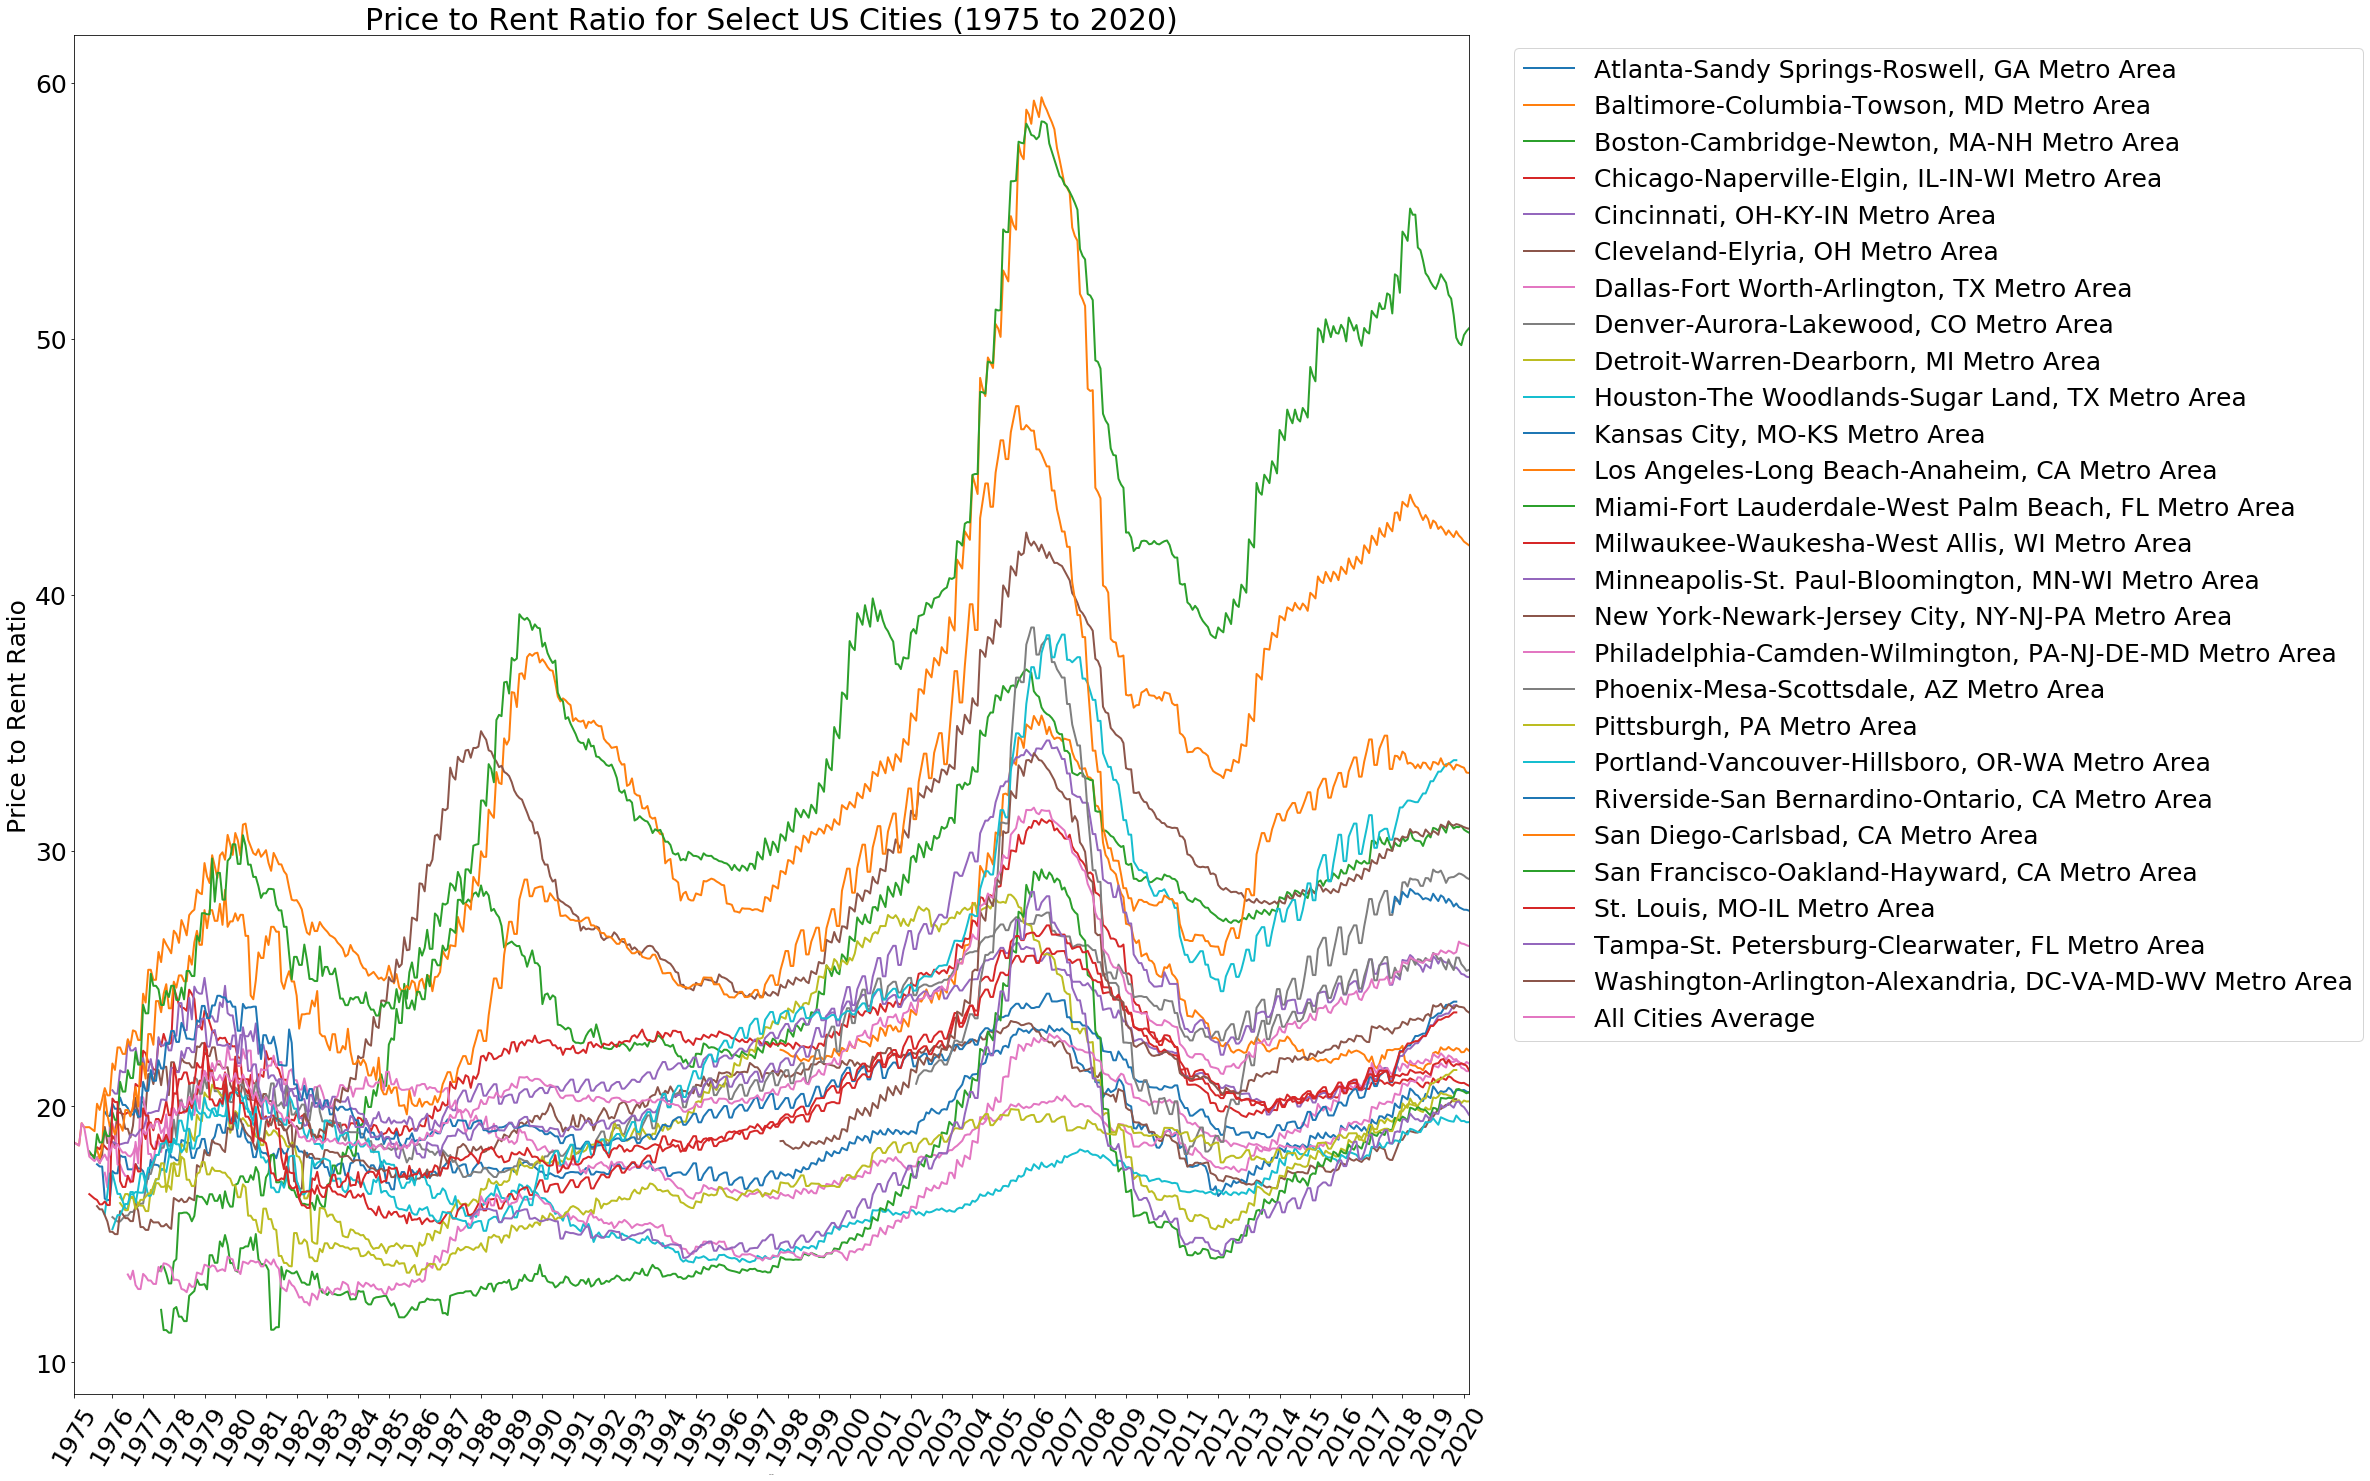

In [433]:
ax = price_to_rent_df_main_pivot.plot(
    figsize=(25,25),
    legend=True,
    linewidth=2,
    markersize=0,
)
plt.legend(loc='upper right', bbox_to_anchor=(1.65, 1))
plt.rcParams.update({'font.size': 25})

ax.set_title('Price to Rent Ratio for Select US Cities (1975 to 2020)',
             fontdict={'fontsize': 30, 'fontweight': 'medium'})
plt.xticks(
    [i for n,i in enumerate(price_to_rent_df_main_pivot.index) if n%12==0],
    rotation=60
)
plt.xlabel('Year', fontsize=2)
plt.ylabel('Price to Rent Ratio', fontsize=25)
plt.margins(x=0)
plt.savefig('images/1975_to_2020_PTR.jpg',  dpi=300, bbox_inches = "tight")
plt.show()

# Compute and Plot Price to Rent Ratios as Indexed Values

In [438]:
date = datetime.date(1977,11,1)
exclude_areas = [
    "Tampa-St. Petersburg-Clearwater, FL Metro Area",
    "Baltimore-Columbia-Towson, MD Metro Area",
    "Washington-Arlington-Alexandria, DC-VA-MD-WV Metro Area",
    "Phoenix-Mesa-Scottsdale, AZ Metro Area",
    "Riverside-San Bernardino-Ontario, CA Metro Area",
]

price_to_rent_df_main_pivot_index = price_to_rent_df_main_pivot.drop(exclude_areas, axis=1)
price_to_rent_df_main_pivot_index = price_to_rent_df_main_pivot_index.loc[price_to_rent_df_main_pivot_index.index>=date]

indexed_timeseries_df = pd.DataFrame()

for i, row in price_to_rent_df_main_pivot_index.reset_index().transpose().iterrows():
    if i == "index":
        indexed_timeseries_df[i] = row
        continue

    first_val = row[0]
    index_vals = [100,]
    for val in row[1:]:
        index_vals.append(val/first_val*100)
    indexed_timeseries_df[i] = pd.Series(index_vals)
    
# Set index to date column (needed for multi line plot)
indexed_timeseries_df = indexed_timeseries_df.set_index("index")

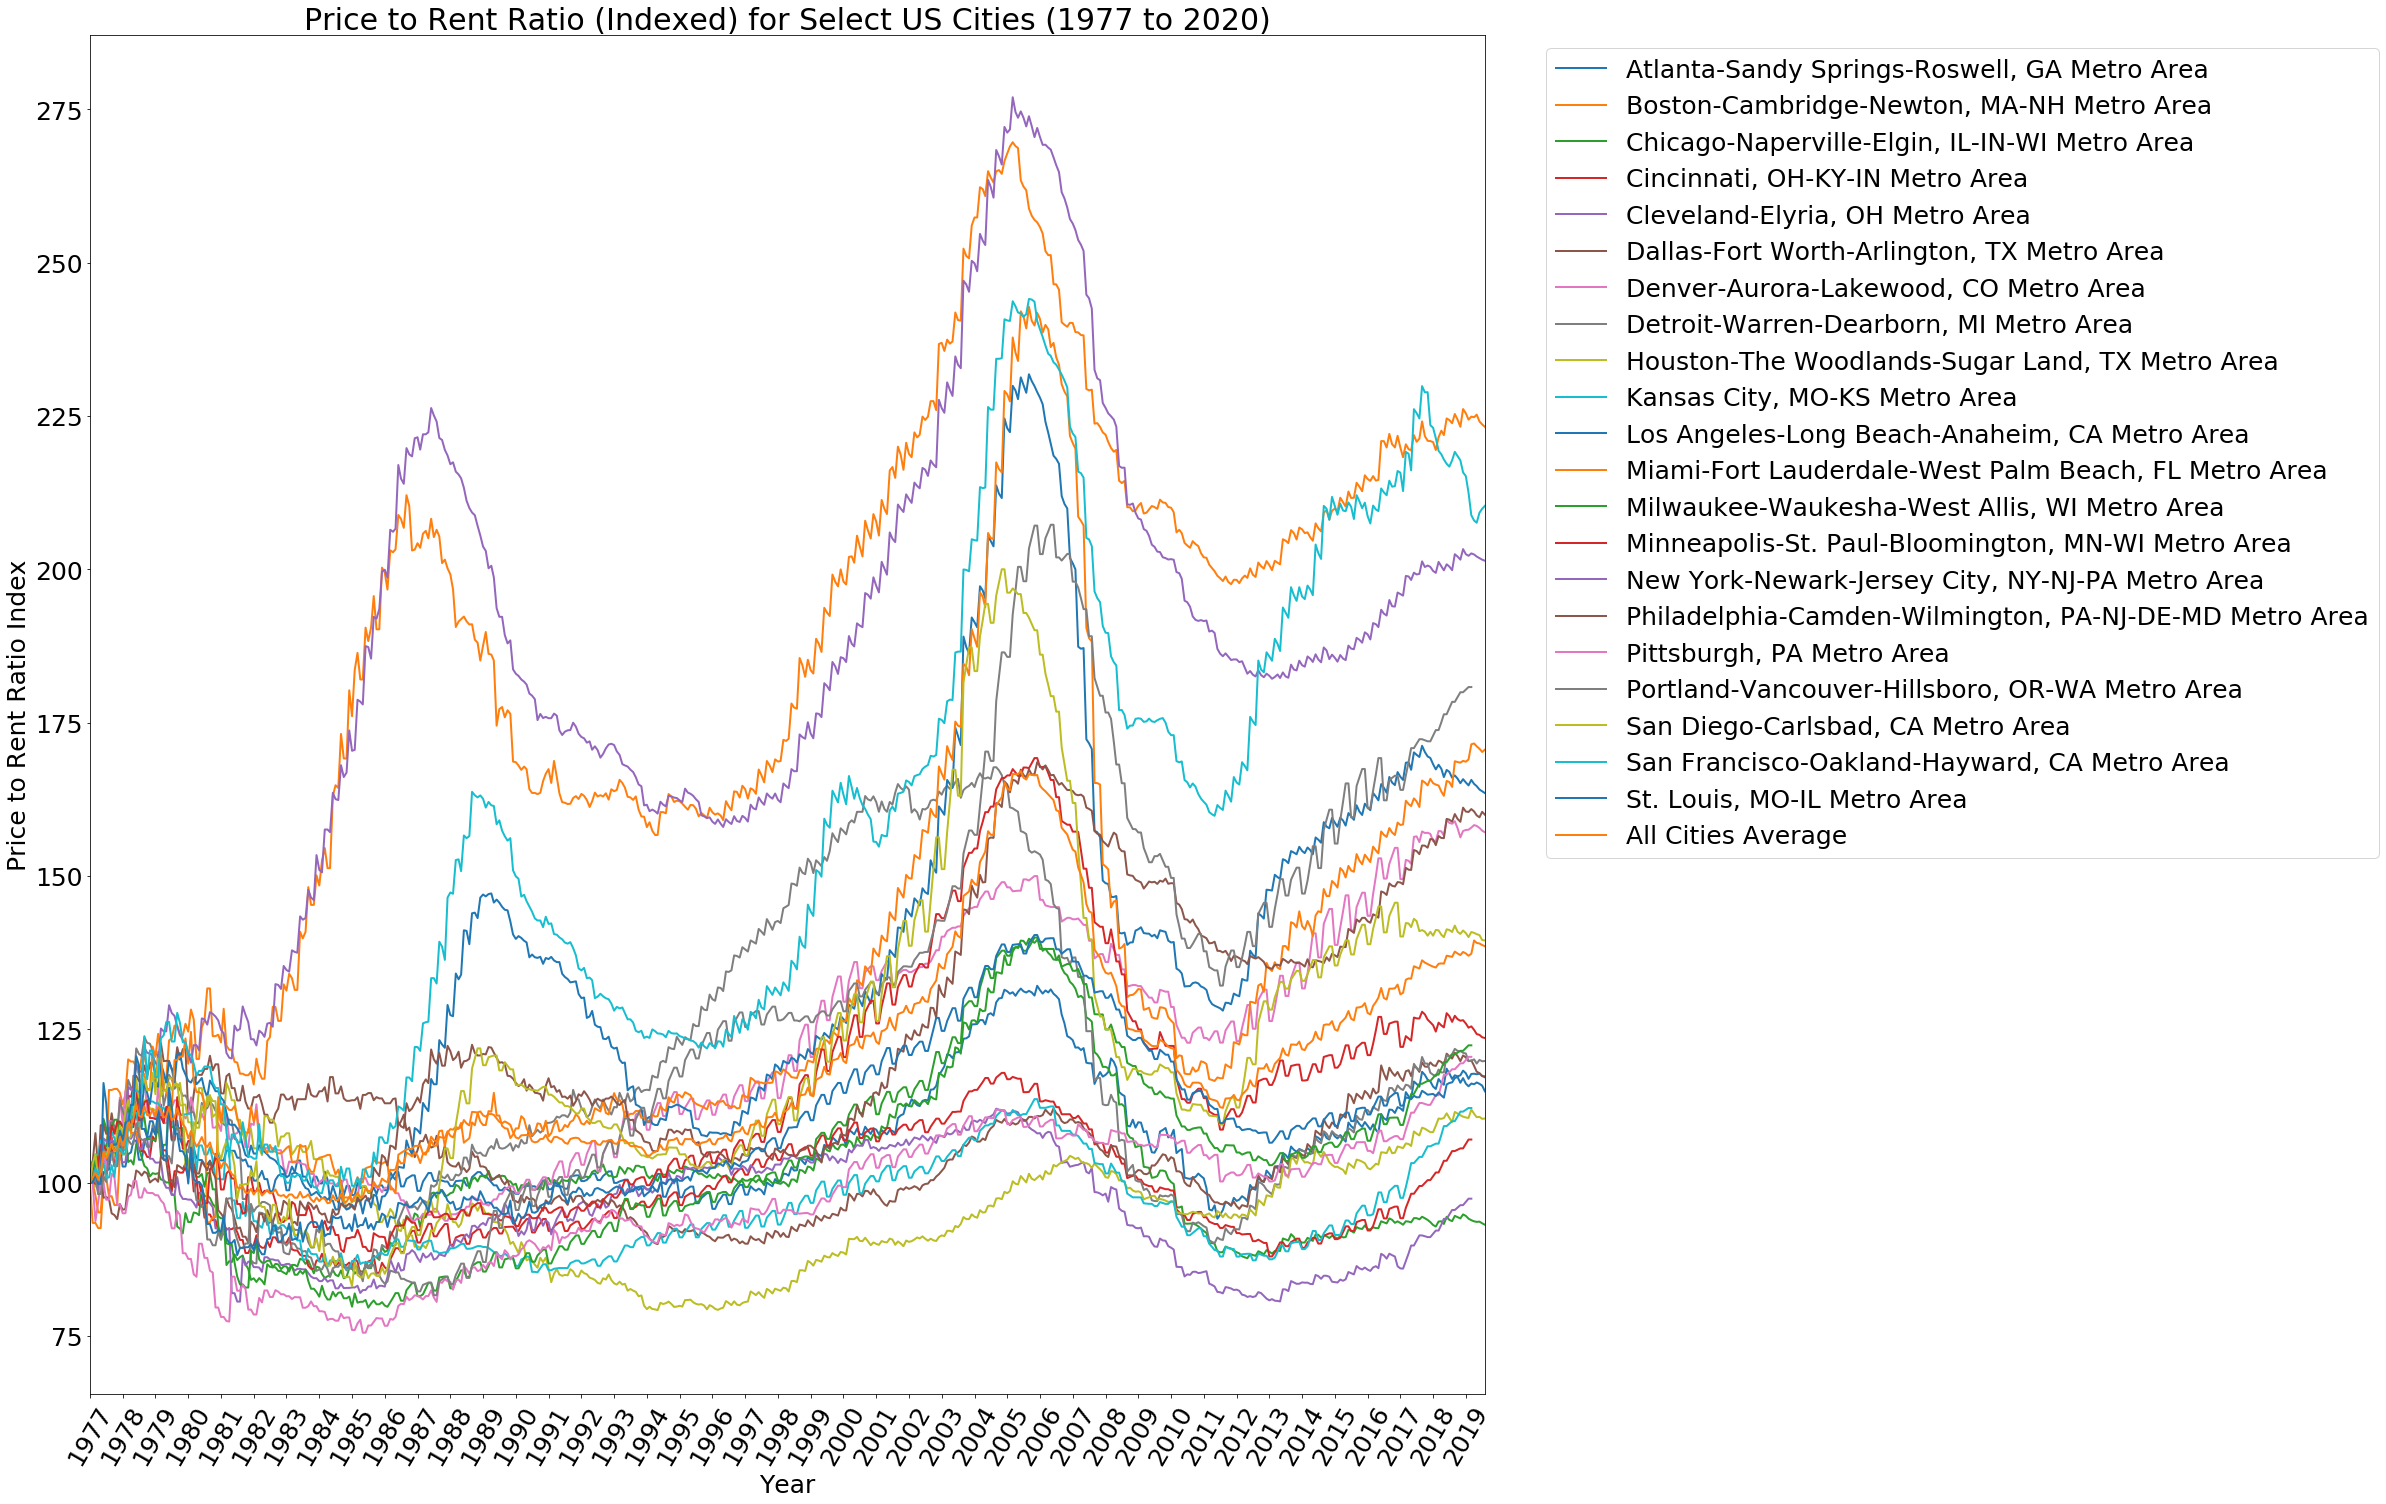

In [439]:
ax = indexed_timeseries_df.plot(
    figsize=(25,25),
    legend=True,
    linewidth=2,
    markersize=0,
)
plt.legend(loc='upper right', bbox_to_anchor=(1.65, 1))
plt.rcParams.update({'font.size': 25})

ax.set_title('Price to Rent Ratio (Indexed) for Select US Cities (1977 to 2020)',
             fontdict={'fontsize': 30, 'fontweight': 'medium'})
plt.xticks(
    [datetime.date(1977,11,1) + relativedelta(years=n) for n in range(2020-1977+1)],
    rotation=60
)
plt.xlabel('Year', fontsize=25)
plt.ylabel('Price to Rent Ratio Index', fontsize=25)
plt.margins(x=0)
plt.savefig('images/1975_to_2020_PTR_indexed.jpg',  dpi=300, bbox_inches = "tight")
plt.show()